In [8]:
import os
import neptune
import torch
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.cm as cm
from fastai.learner import load_learner

In [6]:
device_id = 2
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [ ]:
# Testdatensatz laden
DATASET_DIR = "balanced_dataset_split/balanced_dataset_split"
JSON_PATH = "train_test_split_new.json"

with open(JSON_PATH, "r") as f:
    split_data = json.load(f)

df_test = pd.DataFrame(split_data["test"])
df_test["image_path"] = df_test["file_path"].apply(lambda x: os.path.join(DATASET_DIR, x))

# Vokabular für die Labels erstellen
vocab = df_test["label"].unique().tolist()

# DataBlock für Testdaten
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=vocab)),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
)
dls = dblock.dataloaders(df_test, bs=64, num_workers=8)
test_dl = dls.test_dl(df_test, with_labels=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
# load ViT model from neptune

# Neptune.ai API-Token und Projektname
api_token="insert_your_api_token_here"  # durch tatsächlichen API-Token ersetzen
project_name = "insert_your_project_name_here"  # durch tatsächlichen Projektname ersetzen

run_id = "DLMOD-130"
model_name = "googlenet_bs128+aug"

# Neptune.ai-Projekt initialisieren
project = neptune.init_project(
    project=project_name,
    api_token=api_token,
    mode="read-only"
)

# Neptune Run initialisieren
run = neptune.init_run(
    project=project_name,
    api_token=api_token,
    with_id=run_id,
    mode="read-only"
)
local_model_path = f"basemodel_outputs/{model_name}.pkl"

# Modell aus Neptune herunterladen
model_checkpoint_path = f"model"
run[model_checkpoint_path].download(local_model_path)
print(f"✅ Modell {model_name} erfolgreich heruntergeladen")

# Neptune-Session beenden
run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/katzn13/DL-models/
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/katzn13/DL-models/e/DLMOD-130


Fetching file...: 0 [00:00, ?/s]

✅ Modell googlenet_bs128+aug erfolgreich heruntergeladen
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/katzn13/DL-models/e/DLMOD-130/metadata


In [5]:
# Evaluate ViT models

# Liste der Modelle
models = [
    "basemodel_ViT_bs8",
    "basemodel_ViT_bs16",
    "basemodel_ViT_bs32",
    "basemodel_ViT_bs64",
    "basemodel_ViT_bs128"
]

# Basispfad zu den .pkl-Dateien
base_path = "basemodel_outputs"


# Ergebnisse speichern
results = []

for model_name in models:
    path = f"{base_path}/{model_name}.pkl"
    
    # Modell laden
    learn = load_learner(path)

    # Vorhersagen
    preds, targs = learn.get_preds(dl=test_dl)
    y_pred = torch.argmax(preds, dim=1).numpy()
    y_true = targs.numpy()
    
    # Metriken berechnen
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

# DataFrame mit Ergebnissen
df_results = pd.DataFrame(results)
print(df_results)


                 Model  Accuracy  F1 Score  Precision    Recall
0    basemodel_ViT_bs8  0.870919  0.871205   0.877864  0.870919
1   basemodel_ViT_bs16  0.877951  0.877617   0.886291  0.877951
2   basemodel_ViT_bs32  0.882471  0.881873   0.888366  0.882471
3   basemodel_ViT_bs64  0.899046  0.899423   0.906950  0.899046
4  basemodel_ViT_bs128  0.893521  0.893504   0.901419  0.893521


In [ ]:
# Metriken & Modelle
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
n_metrics = len(metrics)
n_models = len(df_results)
group_width = 1.2  
bar_width = group_width / n_models
gap = 0.5  

# X-Positionen der Metrikgruppen
x = np.arange(n_metrics) * (1 + gap)

# Farben aus der "Blues"-Colormap
cmap = cm.get_cmap('Blues')
colors = [cmap(0.3 + 0.8 * i / max(1, n_models - 1)) for i in range(n_models)]

# Mapping der Modellnamen für schönere Beschriftung
label_map = {
    "basemodel_ViT_bs8": "8",
    "basemodel_ViT_bs16": "16",
    "basemodel_ViT_bs32": "32",
    "basemodel_ViT_bs64": "64",
    "basemodel_ViT_bs128": "128"
}

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

for i, (idx, row) in enumerate(df_results.iterrows()):
    scores = [row[m] for m in metrics]
    offset = x + i * bar_width - group_width / 2 + bar_width / 2
    label = label_map.get(row['Model'], row['Model'])
    ax.bar(offset, scores, width=bar_width, label=label, color=colors[i])

# Achsen & Styling
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Metrics for ViT with different batch sizes', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_yticks(np.linspace(0, 1.0, 6))
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylim(0, 1.05)

# Legende
ax.legend(title="Batch Size", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Gitter und Layout
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/vit_batchsize_metrics.png", dpi=300)
plt.show()

In [4]:
# Evaluation Tuning mit ViT

# Liste der Modelle
models = [
    "basemodel_ViT_bs64",
    "basemodel_ViT_bs64+augm",
    "basemodel_ViT_bs64+augm+iNat"
]

# Basispfad zu den .pkl-Dateien
base_path = "basemodel_outputs"


# Ergebnisse speichern
results = []

for model_name in models:
    path = f"{base_path}/{model_name}.pkl"
    
    # Modell laden
    learn = load_learner(path)

    # Vorhersagen
    preds, targs = learn.get_preds(dl=test_dl)
    y_pred = torch.argmax(preds, dim=1).numpy()
    y_true = targs.numpy()
    
    # Metriken berechnen
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

# DataFrame mit Ergebnissen
df_results = pd.DataFrame(results)
print(df_results)


                          Model  Accuracy  F1 Score  Precision    Recall
0            basemodel_ViT_bs64  0.899046  0.899423   0.906950  0.899046
1       basemodel_ViT_bs64+augm  0.899046  0.898600   0.903551  0.899046
2  basemodel_ViT_bs64+augm+iNat  0.903064  0.902951   0.906097  0.903064


/tmp/ipykernel_4187651/2565579375.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


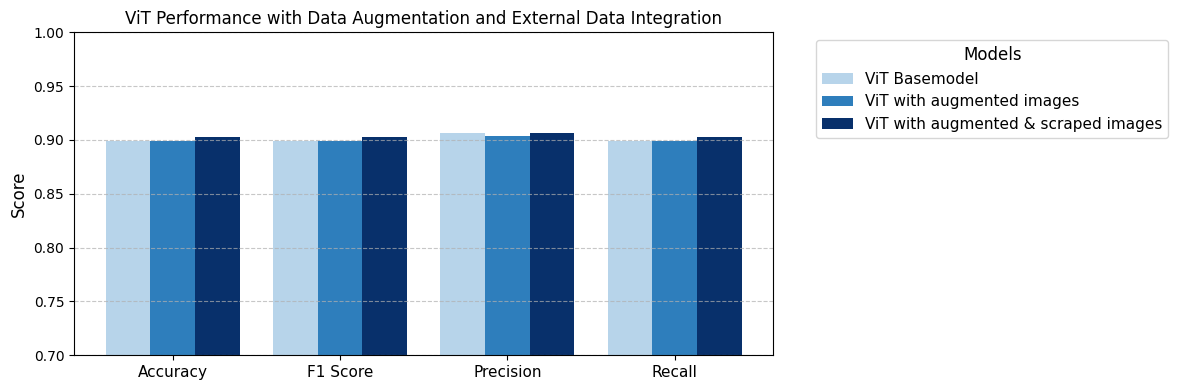

In [ ]:
# Metriken & Modelle
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
n_metrics = len(metrics)
n_models = len(df_results)
group_width = 1.2  
bar_width = group_width / n_models
gap = 0.5  

# X-Positionen der Metrikgruppen
x = np.arange(n_metrics) * (1 + gap)

# Farben aus der "Blues"-Colormap
cmap = cm.get_cmap('Blues')
colors = [cmap(0.3 + 0.8 * i / max(1, n_models - 1)) for i in range(n_models)]

# Mapping der Modellnamen für schönere Beschriftung
label_map = {
    "basemodel_ViT_bs64": "ViT Basemodel",
    "basemodel_ViT_bs64+augm": "ViT with augmented images",
    "basemodel_ViT_bs64+augm+iNat": "ViT with augmented & scraped images"
}

# Plot
fig, ax = plt.subplots(figsize=(12, 4))

for i, (idx, row) in enumerate(df_results.iterrows()):
    scores = [row[m] for m in metrics]
    offset = x + i * bar_width - group_width / 2 + bar_width / 2
    label = label_map.get(row['Model'], row['Model'])  # Fallback auf Originalname
    ax.bar(offset, scores, width=bar_width, label=label, color=colors[i])

# Achsen & Styling
ax.set_ylabel('Score', fontsize=12)
ax.set_title('ViT Performance with Data Augmentation and External Data Integration')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(0.7, 1.0)
ax.legend(title="Models", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/ViT_tuning_metrics.png", dpi=300)
plt.show()